In [12]:
import numpy as np
from numpy.random import normal, uniform, multivariate_normal

from sklearn.linear_model import Ridge as Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
result_repository = "./outputs/criterion_ablation_"
output_figure_path = "./figures/"
figure_name = "MLRvsCV_CriterionComparison.pdf"

In [15]:
n_simulations = 100 # number of times the experiment is repeated
split_seed = 0 #train test split seed
permut_seed = 0 #mlr label shuffling seed

train_size = 100
test_size = 1000
n, p =  test_size+train_size, 80
normalize_X = True
normalize_y = True
alphas = np.geomspace(1e1,1e5,100)
folds = 10 #averaging over 10 Kfold cross-validation evaluations

In [16]:
def generate_correlated_linear_model(n, p, seed):
    np.random.seed(seed)
    noise = 100
    coef_toeplitz = 0.8
    cov = (coef_toeplitz**uniform(1,2, size = (p,p))) * (np.ones((p,p))-np.eye(p)) + np.eye(p)
    X = multivariate_normal(mean = np.zeros(p), cov = cov, size = n)
    coef = np.ones((p))
    y = X.dot(coef) + normal(scale = noise, size = n)
    return X, y, cov

In [17]:
# Ridge scikit-learn parameters
fit_intercept = True
normalize = False

perf_test, perf_cvs, perf_perms = [], [], []
for seed in range(n_simulations):
    X, y, cov = generate_correlated_linear_model(n, p, seed)
    if normalize_X: X = StandardScaler().fit_transform(X)
    if normalize_y:
        m, s = y.mean(), y.std()
        y_rescaled = (y - m) / s
    else:
        y_rescaled = y

    kwargs = {}
    if split_seed or type(split_seed)== type(0):
        kwargs["random_state"] = split_seed
        np.random.seed(split_seed)
    X_train, X_test, y_train, y_test = tts(X, y_rescaled, train_size = train_size, **kwargs)
    
    n_permuts = 16 #ONLY FOR REPRODUCTIBILITY IN TERMS OF RANDOM SEED, BUT REPORTED RESULTS ARE BASED ON ONLY ONE SET OF RANDOM PERMUTATIONS
    only_seed_used = 0 #USING 16 PERMUTATION VECTORS FOR DEEP LEARNING BUT NOT FOR THIS EXPERIMENT, SEE THEOREM 1.
    y_perms = np.zeros((n_permuts, len(y_train)))
    for permut_seed in range(n_permuts):
        y_perms[permut_seed] = shuffle(y_train, random_state = permut_seed)
    mse_perms = np.zeros((len(alphas), n_permuts))
    mse_train = np.zeros(len(alphas))
    mse_test = np.zeros(len(alphas))
    mse_cvs = np.zeros((len(alphas),folds))
    r2_test = np.zeros(len(alphas))
    r2_train = np.zeros(len(alphas))

    for i, alpha in enumerate(alphas):
        reg = Ridge(alpha = alpha,  fit_intercept=fit_intercept, normalize=normalize,random_state=42)
        reg.fit(X_train, y_train)
        pred_train = reg.predict(X_train)
        pred_test = reg.predict(X_test)

        mse_train[i] = mse(y_train, pred_train)
        mse_test[i] = mse(y_test, pred_test)
        r2_test[i] = r2_score(y_test, pred_test)
        r2_train[i] = r2_score(y_train, pred_train)

        for fold in range(folds):
            X_train_cv, X_test_cv, y_train_cv, y_test_cv = tts(X_train, y_train, train_size = 1. - (1/folds), random_state = fold)
            reg = Ridge(alpha = alpha,  fit_intercept=fit_intercept, normalize=normalize,random_state=42)
            reg.fit(X_train_cv, y_train_cv)
            pred_cv = reg.predict(X_test_cv)
            mse_cvs[i, fold] = mse(y_test_cv, pred_cv)
        for permut_seed in range(n_permuts):#USELESS LOOP BESIDES FIRST PASS, ONLY KEPT FOR REPRODUCTIBILITY
            y_perm = y_perms[permut_seed]
            reg = Ridge(alpha = alpha, fit_intercept=fit_intercept, normalize=normalize,random_state=42)
            reg.fit(X_train, y_perm)
            pred_perm = reg.predict(X_train)
            mse_perms[i, permut_seed] = mse(y_perm, pred_perm)
    argmin_test = np.argmin(mse_test)
    argmin_cvs = np.argmin(mse_cvs.mean(axis=-1))
    #ONLY THE FIRST RANDOM PERMUTATION VECTOR IS USED, OTHERS ARE DISCARDED
    argmin_perms = np.argmin(mse_train - mse_perms[:,only_seed_used])
    perf_test.append(mse_test[argmin_test])
    perf_cvs.append(mse_test[argmin_cvs])
    perf_perms.append(mse_test[argmin_perms])

    if seed == 0:#keep seed 0 results for plot
        plotted_mse_test = mse_test
        plotted_mse_train = mse_train
        plotted_mse_cvs = mse_cvs
        plotted_mse_perms = mse_perms    

/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/sit

/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/opt/tljh/user/envs/MLR/lib/python3.7/sit

In [20]:
avg_added_error_cvs = np.array(perf_cvs) - np.array(perf_test)
avg_added_error_perms = np.array(perf_perms) - np.array(perf_test)
printed_results = {"Results averaged over:":str(n_simulations)+" random seeds",
    "optimal test RMSE:" : np.array(perf_test).mean(), 
    "MLR criterion test RMSE:" : np.array(perf_perms).mean(),
    "CV criterion test RMSE:" : np.array(perf_cvs).mean(),
    "MLR criterion added error:": avg_added_error_perms.mean(),
    "CV criterion added error":avg_added_error_cvs.mean()
    }
for key, value in printed_results.items():
    print(key, value)

Results averaged over: 100 random seeds
optimal test RMSE: 0.7061169607942872
MLR criterion test RMSE: 0.7128178158404265
CV criterion test RMSE: 0.7221513770143744
MLR criterion added error: 0.00670085504613921
CV criterion added error 0.016034416220087097


In [25]:
np.save(result_repository+"AllSeedArgmin_MLR_RMSE", np.array(perf_perms))
np.save(result_repository+"AllSeedArgmin_CV_RMSE", np.array(perf_cvs))
np.save(result_repository+"AllSeedArgmin_GEN_RMSE", np.array(perf_test))
np.save(result_repository+"Seed0"+"_Alphas", alphas)
np.save(result_repository+"Seed0"+"_MLR_RMSE", plotted_mse_perms)
np.save(result_repository+"Seed0"+"_CV_RMSE", plotted_mse_cvs)
np.save(result_repository+"Seed0"+"_Train_RMSE", plotted_mse_train)
np.save(result_repository+"Seed0"+"_GEN_RMSE", plotted_mse_test)

In [22]:
def rescale(vec):
    mi, ma, v = np.min(vec), np.max(vec), np.array(vec)
    return (v - mi)/ (ma - mi)

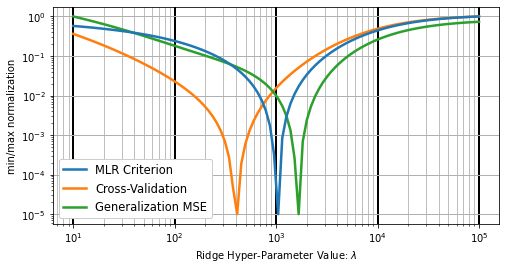

In [23]:
add_title = False #No title on ICML plots
avg_added_error_cvs = np.array(perf_cvs) - np.array(perf_test)
avg_added_error_perms = np.array(perf_perms) - np.array(perf_test)

plt.rcParams["figure.figsize"] = (8,4)
if add_title: plt.title(r'Ridge $\lambda$ HPO criterion: MLR vs Cross-Validation Argmins')

epsilon_logscale = 1e-5 #used to avoid 0s when using min-max scaling and logscale plots
mlr_criterion = rescale(plotted_mse_train - plotted_mse_perms.mean(axis=1)) + epsilon_logscale
cv_criterion = rescale(plotted_mse_cvs.mean(axis=-1)) + epsilon_logscale
gen_perf = rescale(plotted_mse_test) + epsilon_logscale

avg_perf_perms, avg_perf_cvs, avg_perf_test, = np.array(perf_perms).mean(), np.array(perf_cvs).mean(), np.array(perf_test).mean()
linestyle2 = "-"
plot_func = "loglog"
eval("plt."+plot_func)([1e5], [1], label = "MLR Criterion", 
             linewidth = 2.5, linestyle = linestyle2, color = "tab:blue")#plotting empty curve to have different label and plot order to improve visibility
eval("plt."+plot_func)(alphas, cv_criterion, label = "Cross-Validation", 
             linewidth = 2.5, linestyle = linestyle2, color = "tab:orange")
eval("plt."+plot_func)(alphas, gen_perf, label = "Generalization MSE", 
             linewidth = 2.5, linestyle = linestyle2, color = "tab:green")
eval("plt."+plot_func)(alphas, mlr_criterion,
             linewidth = 2.5, linestyle = linestyle2, color = "tab:blue")
plt.xlabel(r'Ridge Hyper-Parameter Value: $\lambda$')
plt.ylabel("min/max normalization")
plt.grid(which = "both", axis = "x")
plt.grid(which = "major", axis = "y", linewidth = 1)
plt.grid(which = "major", axis = "x", linewidth = 2, color = "k")
_ = plt.legend(prop={'size': 11.5}, framealpha=1.)
plt.savefig(output_figure_path + figure_name, dpi='figure', format="pdf",bbox_inches='tight')